In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
data.head()
X = data.iloc[:,[5]]
Y = data.iloc[:,0]
Y[Y == 4] = 1


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5428\999472746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y == 4] = 1


In [4]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Text-preprocessing

# Missing Values
num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
data = data.dropna()

TAG_CLEANING_RE = "@\S+"
# Remove @tags
X['text'] = X['text'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
X['text'] = X['text'].map(lambda x: x.lower())

# Remove numbers
X['text'] = X['text'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['text'] = X['text'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
X['text']  = X['text'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
X['text'] = X['text'].map(lambda x: x.strip())

# Tokenize into words
X['text'] = X['text'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
X['text'] = X['text'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
stop_words = set(stopwords.words('english'))
X['text'] = X['text'].map(lambda x: [w for w in x if not w in stop_words])
    
# Word Lemmatization
lem = WordNetLemmatizer()
X['text'] = X['text'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
X['text'] = X['text'].map(lambda x: ' '.join(x))

Number of missing values: 0


In [6]:
X.head()

,text
0,zl awww bummer shoulda get david carr third day
1,upset update facebook texting might cry result...
2,dive many time ball manage save rest go bound
3,whole body feel itchy like fire
4,behave mad see


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_train))

TRAIN size: 1280000
TEST size: 1280000


In [8]:
# WORD2VEC 
import gensim

W2V_VECTOR_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in X_train.text] 
w2v_model = gensim.models.Word2Vec(vector_size=W2V_VECTOR_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=8)
w2v_model.build_vocab(documents)


In [9]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size:", vocab_size)


Vocab size: 25276


In [10]:
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(251374270, 289225504)

In [11]:
similar_words = w2v_model.wv.most_similar("great")
print(similar_words)


[('fantastic', 0.7345731854438782), ('wonderful', 0.7094806432723999), ('good', 0.6920195817947388), ('awesome', 0.6804642677307129), ('amaze', 0.6315257549285889), ('fabulous', 0.5954301953315735), ('fab', 0.5922024250030518), ('nice', 0.5743895173072815), ('excellent', 0.5710744261741638), ('lovely', 0.5445038676261902)]


In [12]:
# Tokenizing
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
#from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train.text)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)


Found 232838 unique tokens.
Shape of data tensor: (1280000, 300)


In [13]:
pip install keras


In [14]:
# Assuming you have defined W2V_SIZE earlier in your code
W2V_SIZE = 300  # or any other value you want

# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [15]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [17]:
# Build Model
from keras.layers import Conv1D, GlobalMaxPooling1D
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(300,3,activation='relu'))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          69851700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 298, 300)          270300    
                                                                 
 global_max_pooling1d (Glob  (None, 300)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                       

In [18]:
# Training 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=512,
                    epochs=3,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/3


2250/2250 [==============================] - 1472s 654ms/step - loss: 0.4927 - accuracy: 0.7587 - val_loss: 0.4679 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 2/3
2250/2250 [==============================] - 1468s 652ms/step - loss: 0.4737 - accuracy: 0.7716 - val_loss: 0.4606 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 3/3
2250/2250 [==============================] - 1468s 652ms/step - loss: 0.4666 - accuracy: 0.7760 - val_loss: 0.4579 - val_accuracy: 0.7815 - lr: 0.0010


In [18]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()



625/625 [==============================] - 98s 155ms/step - loss: 0.8804 - accuracy: 0.4984
ACCURACY: 0.49841874837875366
LOSS: 0.8804027438163757


NameError: name 'history' is not defined

In [20]:
# Assuming 'model' is your trained machine learning model
# Assuming 'X_train', 'y_train', 'X_val', 'y_val' are your training and validation data
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Now 'history' should be defined and accessible
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']

# You can then proceed to use 'acc', 'val_acc', and 'loss' as needed
print("ACCURACY:", acc)
print("VALIDATION ACCURACY:", val_acc)
print("LOSS:", loss)


NameError: name 'X_val' is not defined

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [22]:
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)

In [23]:
y_pred = model.predict(X_test_padded)

10000/10000 [==============================] - 105s 10ms/step


In [24]:
y_pred_binary = (y_pred > 0.5).astype(int)

Accuracy: 0.49841875
Precision: 0.0
Recall: 0.0


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.0
ROC-AUC Score: 0.5390757834299721


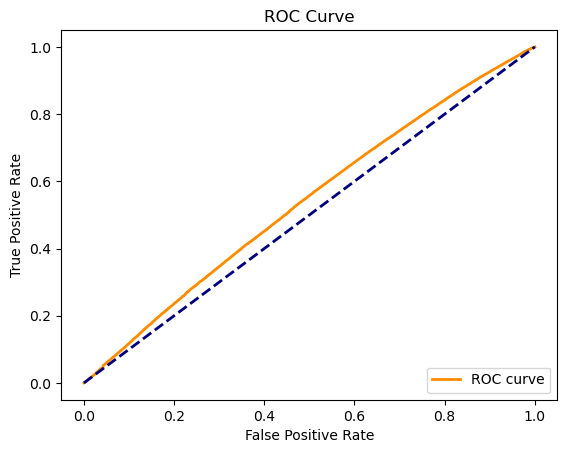

In [25]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
import matplotlib.pyplot as plt

In [27]:
model.save('/kaggle/working/Sentiment_CNN_model.keras')


In [28]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score <=0.4):
        label = "Negative"
    if(score >=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)} 

In [32]:
predict("Today is wednesday. i had a very bad day at college. my life sucks. i love my parents")

1/1 [==============================] - 0s 14ms/step


{'label': 'Negative', 'score': 0.1795705109834671}

In [33]:
predict("Ehsaas is happpy")

1/1 [==============================] - 0s 14ms/step


{'label': 'Negative', 'score': 0.2735113203525543}

In [43]:
from keras.optimizers import Adam

In [44]:
BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 0.001

In [45]:
from keras.models import Sequential
from keras.layers import Dense

# Example: Define a simple model
model = Sequential()
model.add(Dense(10, input_dim=8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
import tensorflow as tf
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(loss=tf.compat.v1.losses.sparse_softmax_cross_entropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)